In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=""

import numpy as np
import ngmix
import galsim
import autometacal
import tensorflow as tf
import galflow
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Generate some data, any old data will do
def make_data(rng, noise, shear):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    psf_noise = 1.0e-6

    scale = 0.263
    stamp_size = 45
    psf_fwhm = 0.9
    gal_hlr = 0.5
    dy, dx = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(
        beta=2.5, fwhm=psf_fwhm,
    ).shear(
        g1=0.0,
        g2=0.0,
    )

    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(
        dx=dx,
        dy=dy,
    )

    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    im = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array

    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    im += rng.normal(scale=noise, size=im.shape)

    cen = (np.array(im.shape))/2.0
    psf_cen = (np.array(psf_im.shape))/2.0

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0], col=cen[1], scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    wt = im*0 + 1.0/noise**2
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )

    return obs

In [3]:
args={'seed':31415,
      'ntrial':1000,
      'noise': 1e-5,
      'psf': 'gauss'}
shear_true = [0.0, 0.00]
rng = np.random.RandomState(args['seed'])

In [4]:
obs = make_data(rng=rng, noise=args['noise'], shear=shear_true)

In [5]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent

boot = ngmix.metacal.MetacalBootstrapper(
    runner=runner, psf_runner=psf_runner,
    rng=rng,
    psf=args['psf'],
    step=0.01,
    fixnoise=False
)

dlist = []

In [6]:
resdict, obsdict = boot.go(obs)

In [7]:
# Compute FFT of input postage stamp of the galaxy image
i = ifftshift(obs.image) # This shift is necessary to avoid a weird phase appearing in the Fourier image
im = tf.convert_to_tensor(i.reshape([1,45,45]), tf.float32)
imk = tf.signal.fftshift(tf.signal.fft2d(tf.cast(im, tf.complex64)))

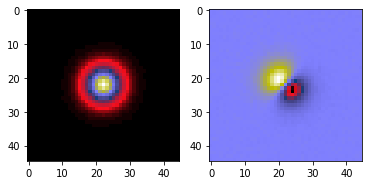

In [8]:
# Plotting real and imaginary images
subplot(121)
imshow((imk[0].numpy().real),cmap='gist_stern')
subplot(122)
imshow((imk[0].numpy().imag),cmap='gist_stern')

In [9]:
# Compute FFT of PSF image
psf = tf.convert_to_tensor(obs.psf.image.reshape([1,45,45]), tf.float32)
kpsf = tf.cast(tf.abs(tf.signal.fft2d(tf.cast(psf, tf.complex64))), tf.complex64) # Note the abs here, to remove the phase of the PSF
kpsf = tf.signal.fftshift(kpsf)

# Compute FFT of reconvolution PSF image
rpsf = tf.convert_to_tensor(obsdict['noshear'].psf.image.reshape([1,45,45]), tf.float32)
krpsf = tf.cast(tf.abs(tf.signal.fft2d(tf.cast(rpsf, tf.complex64))), tf.complex64)
krpsf = tf.signal.fftshift(krpsf)

In [10]:
# compute mask in Fourier space to kill too high frequencies that may arise during deconvolution
kx, ky = meshgrid(fftfreq(45), fftfreq(45))
mask = sqrt(kx**2 + ky**2) <= 0.5
mask = fftshift(mask)

In [11]:
# Deconvolve obs by PSF
im_deconv = imk * ( (1./(kpsf+1e-10))*mask)

In [12]:
# Apply 0 shear
im_sheared = galflow.shear(tf.expand_dims(im_deconv,-1), 
                           atleast_1d(0.0), atleast_1d(0.0))[...,0]

im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared* krpsf * mask))
im_reconv = tf.math.real(tf.signal.fftshift(im_reconv))

Text(0.5, 0.98, 'noshear')

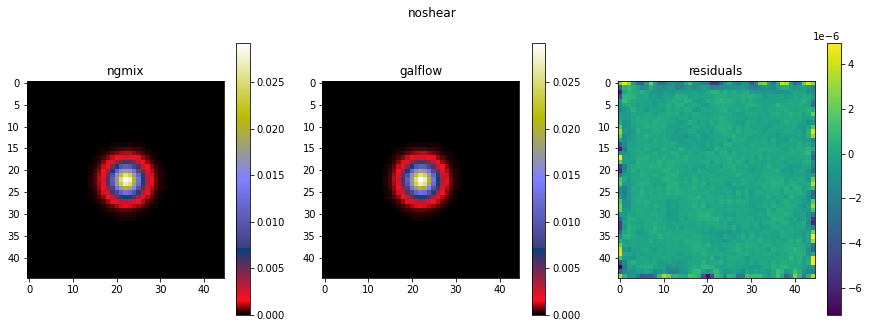

In [13]:
figure(figsize=[15,5])
subplot(131)
title('ngmix')
imshow(obsdict['noshear'].image,cmap='gist_stern'); colorbar()
subplot(132)
imshow(im_reconv[0,:,:],cmap='gist_stern'); colorbar()
title('galflow')
subplot(133)
imshow(im_reconv[0,:,:] - obsdict['noshear'].image); colorbar()
title('residuals')
suptitle('noshear')

In [14]:
# Apply 1p shear
im_sheared = galflow.shear(tf.expand_dims(im_deconv,-1), 
                           atleast_1d(0.01), atleast_1d(0.0))[...,0]

im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared* krpsf * mask))
im_reconv = tf.math.real(tf.signal.fftshift(im_reconv))

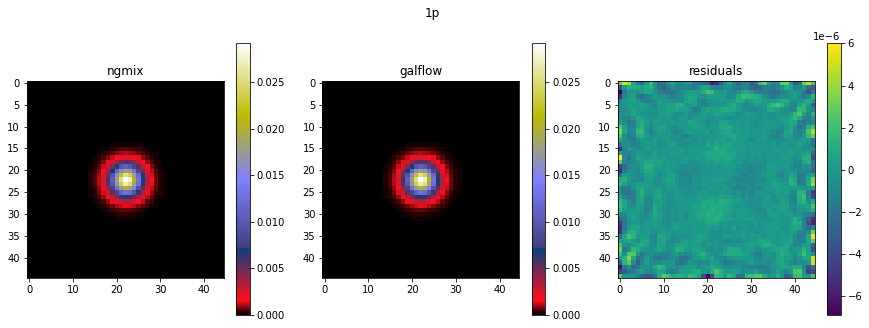

In [15]:
figure(figsize=[15,5])
subplot(131)
title('ngmix')
imshow(obsdict['1p'].image,cmap='gist_stern'); colorbar()
subplot(132)
imshow(im_reconv[0,:,:],cmap='gist_stern'); colorbar()
title('galflow')
subplot(133)
imshow(im_reconv[0,:,:] - obsdict['1p'].image); colorbar()
title('residuals')
suptitle('1p');

In [16]:
# Apply 2p shear
im_sheared = galflow.shear(tf.expand_dims(im_deconv,-1), 
                           atleast_1d(0.00), atleast_1d(0.01))[...,0]

im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared* krpsf * mask))
im_reconv = tf.math.real(tf.signal.fftshift(im_reconv))

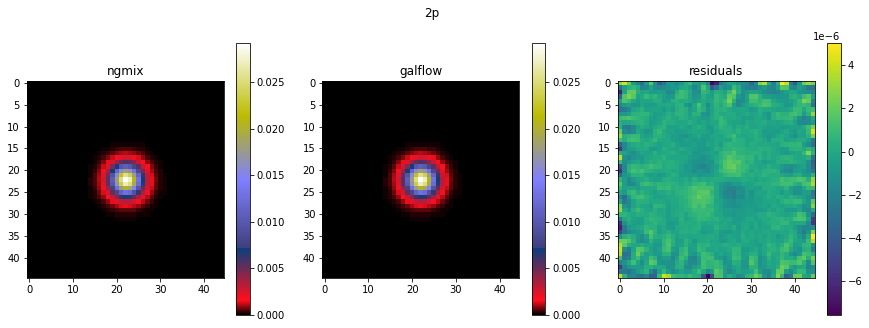

In [17]:
figure(figsize=[15,5])
subplot(131)
title('ngmix')
imshow(obsdict['2p'].image,cmap='gist_stern'); colorbar()
subplot(132)
imshow(im_reconv[0,:,:],cmap='gist_stern'); colorbar()
title('galflow')
subplot(133)
imshow(im_reconv[0,:,:] - obsdict['2p'].image); colorbar()
title('residuals')
suptitle('2p');

Text(0.5, 1.0, 'residuals between sheared and non-sheared images')

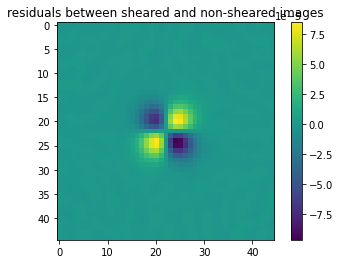

In [19]:
# And just for comparison, here is the difference between sheared and non sheared version of the galaxy
imshow(obsdict['noshear'].image - obsdict['2p'].image); colorbar()
title('residuals between sheared and non-sheared images')